Analyses properties of decorrelation and whitening methods for FC and Convolutional cases.

In [1]:
import numpy as np
import torch
from decorrelation.decorrelation import lower_triangular,Decorrelation, DecorConv2d # DecorrelationPatch2d # covariance, DecorrelationPatch2d, DecorrelationFC, lower_triangular
from decorrelation.plotting import *

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def decorrelate(num_epochs, data, model, decor_lr):

    # covariance matrix before training
    X = model.decorrelate(data).view(data.shape[0],-1)
    A1 = (X.T @ X) / len(X)

    # train decorrelator
    L = np.zeros(num_epochs)
    for i in range(num_epochs):
        model.forward(data)
        L[i] = model.update()
        model.weight -= decor_lr * model.weight.grad
        if model.bias is not None:
            model.bias -= decor_lr * model.bias.grad
    
        # covariance matrix after training
    X = model.decorrelate(data).view(data.shape[0],-1)
    A2 = (X.T @ X) / len(X)

    return L, A1, A2

In [3]:
num_samples=1000
num_features=100
num_epochs=1000
seed=42
decor_lr=1e1

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# generate correlated data
d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.8 * torch.eye(num_features) + 0.2 * torch.ones((num_features, num_features)))
data = d.sample((num_samples,)).to(device)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

kappas = np.linspace(0,1,20)
D = np.zeros(len(kappas))
C = np.zeros(len(kappas))
for i, kappa in enumerate(kappas):

    model = Decorrelation(in_features=num_features, bias=True, kappa=kappa).to(device)

    L, A1, A2 = decorrelate(num_epochs, data, model, decor_lr)
    
    C[i] = torch.mean(lower_triangular(torch.abs(A2), offset=-1))
    D[i] = torch.mean(torch.diag(A2))


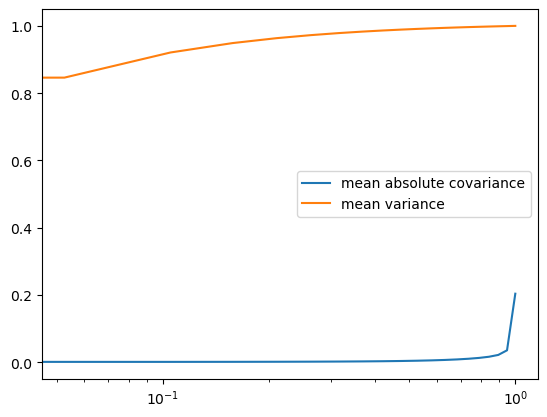

In [4]:
plt.semilogx(kappas, C)
plt.semilogx(kappas, D)
plt.legend(['mean absolute covariance', 'mean variance'])

In [5]:
model.bias

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])